In [73]:
import nemo.collections.asr as nemo_asr
import glob
import librosa
import soundfile
import pydub
import torch
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import model_selection
from sklearn import metrics

import pandas as pd
import numpy as np
import pickle

Initialize MarbleNet

In [32]:
classifier = nemo_asr.models.EncDecClassificationModel.from_pretrained("commandrecognition_en_matchboxnet3x2x64_v2").to('cpu').eval()
labels = classifier.to_config_dict()['labels_full']

[NeMo I 2022-12-16 16:13:09 cloud:56] Found existing object /home/nikita/.cache/torch/NeMo/NeMo_1.13.0/commandrecognition_en_matchboxnet3x2x64_v2/8d5735c9c20648d313720dd95300978d/commandrecognition_en_matchboxnet3x2x64_v2.nemo.
[NeMo I 2022-12-16 16:13:09 cloud:62] Re-using file from: /home/nikita/.cache/torch/NeMo/NeMo_1.13.0/commandrecognition_en_matchboxnet3x2x64_v2/8d5735c9c20648d313720dd95300978d/commandrecognition_en_matchboxnet3x2x64_v2.nemo
[NeMo I 2022-12-16 16:13:09 common:911] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-16 16:13:09 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    labels:
    - visual
    - wow
    - learn
    - backward
    - dog
    - two
    - left
    - happy
    - nine
    - go
    - up
    - bed
    - stop
    - one
    - zero
    - tree
    - seven
    - 'on'
    - four
    - bird
    - right
    - eight
    - 'no'
    - six
    - forward
    - house
    - marvin
    - sheila
    - five
    - 'off'
    - three
    - down
    - cat
    - follow
    - 'yes'
    batch_size: 128
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      shift:
        prob: 1.0
        min_shift_ms: -5.0
        max_shift_ms: 5.0
      white_noise:
        prob: 1.0
        min_level: -90
        max_level: -46


[NeMo I 2022-12-16 16:13:10 save_restore_connector:243] Model EncDecClassificationModel was successfully restored from /home/nikita/.cache/torch/NeMo/NeMo_1.13.0/commandrecognition_en_matchboxnet3x2x64_v2/8d5735c9c20648d313720dd95300978d/commandrecognition_en_matchboxnet3x2x64_v2.nemo.


In [69]:
filenames=[]
records = []
embeds = []
for f in glob.glob("train_samples/*/*.wav"):
    label = f.split('/')[1]
    y, _ = librosa.load(f, sr=16_000)
    input_signal = torch.FloatTensor([y])
    input_signal_length = torch.IntTensor([len(y)])
    res = classifier.forward(input_signal=input_signal, input_signal_length=input_signal_length)
    filenames.append(f)
    records.append(label)
    embeds.append(res.detach().numpy()[0])
embeds = np.array(embeds)

In [70]:
df = pd.DataFrame(filenames, columns=['filepath'])
df['label'] = records
classes = {v:k for (k,v) in enumerate(np.unique(records))}
df['label'] = df['label'].apply(lambda x: classes[x])
y = df['label'].values
d = pd.DataFrame(np.array(embeds), columns=[f'feat_{i}' for i in range(35)])
df = pd.concat([df, d], axis=1)

In [71]:
clf = svm.SVC()
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)

In [72]:
for train_index, test_index in skf.split(embeds, y):
    clf.fit(embeds[train_index], y[train_index])
    y_pred = clf.predict(embeds[test_index])
    print(metrics.balanced_accuracy_score(y[test_index], y_pred))

1.0
0.9074074074074073
0.8888888888888888
0.8888888888888888
0.9305555555555556


In [74]:
pickle.dump(clf, open("svm.pkl", 'wb'))

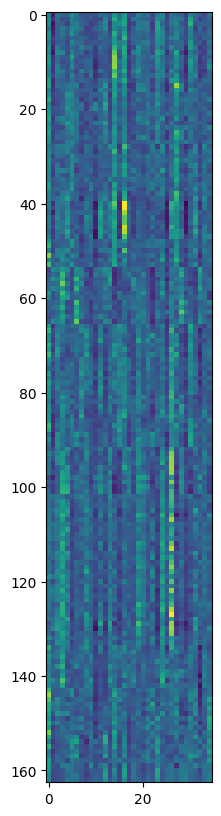

In [78]:
plt.figure(figsize=(4,10))
plt.imshow(embeds)